### Machine Learning Intuition, by Ernst Bolle

Let's say you are an ambitious data analyst and want to further expand your skillset. You have already applied numerous complex algorithms but you want more in-depth knowledge of their inner workings. For starters, you decide to dive into the details of the mother of all algorithms: linear regression. A colleague of yours tipped *The Elements of Statistical Learning* as a great resource, and now you are facing the following formula:

$$ \hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T y $$

For some of you this formula may feel intuitive, but for you, it doesn't. Since you can apply this algorithm with just a few lines of code you decide that it's not worthwhile to further pursue your interest.

#### Intuition matters 

User-friendly APIs like *scikit-learn* make it easy to use very complex models without much in-depth knowledge. This is fine if you want to simply try stuff, but there are a number of reasons you want to avoid this in a more professional setting:

- If you do not know how something works, you will almost certainly not know how to fix it when it stops working
- Your colleagues might question your approach
- Your business stakeholders might want to know what they can learn from your model
- Mastering challenging material can be very rewarding

Do not get me wrong, in my opinion you do not need to know every last detail of an algorithm before you may use it, but having a good intuitive understanding of its inner workings is quite important. Given that the linear algebra approach is out of the question, what other ways are there?

In this article we are going to take a naive approach to solving a simple linear regression task. Although naive, it will uncover an important aspect of machine learning in general, and serve as a gateway to more complex algorithms. Furthermore terms like *parameter space*, *loss function*, and *brute force approach* are intuitively explained. As a bonus, there is python code included to reproduce this approach yourself.

#### Setup 

We are going to solve a simple linear regression task, which means we only have 1 independent variable. The equation:

$$ y = \alpha + \beta x $$ where

- $ \alpha $ is the intercept (in simple linear regression, the point where the line crosses the y-axis)
- $ \beta $ is the slope of the line
- $ x $ is the input variable

The essence of our linear model is that we are looking for a straight line that best fits our data. How we create this line and verify the best fit is discussed shortly, but first let's create a fictive dataset. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
x = np.arange(11)
y = np.array([3, 5.5, 9, 7.5, 11, 5, 8, 11, 18.5, 16, 13.5])

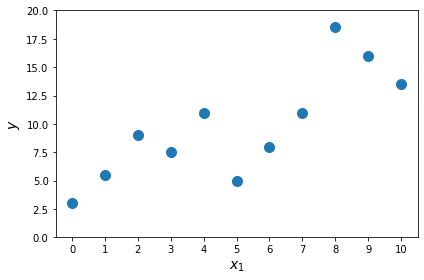

In [4]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o', markersize=10)
ax.set_xlabel('$ x_1 $', fontsize=14)
ax.set_ylabel('$ y $', fontsize=14)
ax.set_xticks(x)
ax.set_ylim([0, 20])

fig.tight_layout()

#### This is where we draw the line
The equation can be translated to an actual line by inserting values for the intercept- and slope parameter. In our example, the intercept refers to the place where the line starts on the y-axis, and the slope determines the steepness. The best fit is the line that minimizes the distance between the line and the data points. 

Since we can visually examine this dataset let's plot a few lines and see which line fits best.

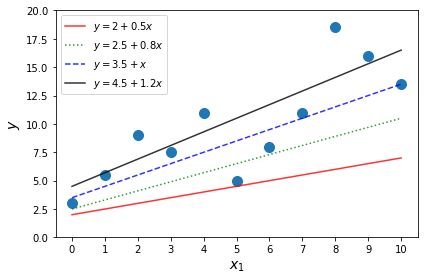

In [5]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o', markersize=10)
plt.plot(x, 2+0.5*x, '-r', alpha=0.8, label='$ y=2+0.5x $')
plt.plot(x, 2.5+0.8*x, ':g', alpha=0.8, label='$ y=2.5+0.8x $')
plt.plot(x, 3.5+x, '--b', alpha=0.8, label='$ y=3.5+x $')
plt.plot(x, 4.5+1.2*x, '-k', alpha=0.8, label='$ y=4.5+1.2x $')

ax.set_xlabel('$ x_1 $', fontsize=14)
ax.set_ylabel('$ y $', fontsize=14)
ax.set_xticks(x)
ax.set_ylim([0, 20])

plt.legend(loc='upper left')

fig.tight_layout()

From this plot I would say the blue dashed line appears to fit best, but how can we decide this more formally? 
A commonly used measure is the root mean square error (RMSE), which returns the average of the sum of squared differences between the observed and predicted values: 

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(Y_i - \hat{Y_i})^2} $$ where

- $ \hat{Y} $ is the prediction
- $ Y $ is the actual observation
- $ i $ is the number of the observation

Visually, this means we are looking for the line with the smallest total length of orange arrows:

In [6]:
# we take the absolute differences for visualization purposes
example_y_hat = 3.5+x
example_diff = abs(y-example_y_hat)

In [7]:
upperlimits = np.array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype='bool')
lowerlimits = np.array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype='bool')

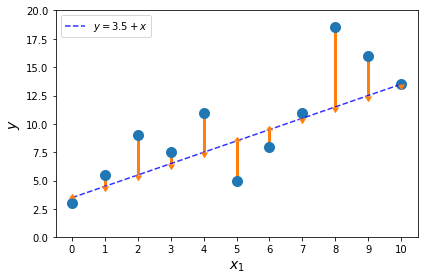

In [8]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o', markersize=10)
plt.plot(x, 3.5+x, '--b', alpha=0.8, label='$ y=3.5+x $')
plt.errorbar(x, y, yerr=example_diff, uplims=upperlimits, lolims=lowerlimits, ls='none', elinewidth=3)

ax.set_xlabel('$ x_1 $', fontsize=14)
ax.set_ylabel('$ y $', fontsize=14)
ax.set_xticks(x)
ax.set_ylim([0, 20])

plt.legend(loc='upper left')

fig.tight_layout()

More information can be found [here](https://en.wikipedia.org/wiki/Root-mean-square_deviation), for now remember that the RMSE is also a *loss function*, an often heard term in the world of Machine Learning which we will revisit at the end of this article. Now that we have our data, a way to make predictions (lines), and a formal measure to check the best fit, we are ready to execute our naive approach.

#### Being naive has it perks

From the second plot we can eyeball which values of the intercept- and slope parameter are likely to result in a decent fit. Our naive approach is to just try a lot of different combinations of these parameter values and look for the combination where the RMSE is at its minimum.

My initial guess would be that the intercept is somewhere between 3 and 5, and the slope between 0.5 and 2.5. We are going to use *itertools* to create every possible combination of this initial guess. 

In [9]:
import itertools as iter

intercept = np.linspace(3, 5, 500) 
slope = np.linspace(0.5, 2.5, 500) 

combination = iter.product(intercept, slope)

Next we are going to execute the linear regression formula and RMSE measure for every combination and save the results as tuples in the result_data list. As a reminder we defined the x and y values as follows:
```python
x = np.arange(11)
y = np.array([3, 5.5, 9, 7.5, 11, 5, 8, 11, 18.5, 16, 13.5])
```

In [10]:
result_data = []

for intercept, slope in combination:
    y_hat = intercept + slope*x    
    rmse = np.sqrt(np.mean((y-y_hat)**2))
    
    result_data.append((intercept, slope, rmse))

In [11]:
result_data[:5]

[(3.0, 0.5, 5.504130680266825),
 (3.0, 0.5040080160320641, 5.483655240723603),
 (3.0, 0.5080160320641283, 5.463205976919804),
 (3.0, 0.5120240480961924, 5.442783183892689),
 (3.0, 0.5160320641282565, 5.422387160739607)]

Since this article is about intuition let's label our results_data list of tuples and visualize it. 

In [12]:
data = {
'intercept': [x[0] for x in result_data],
'slope': [x[1] for x in result_data],
'rmse': [x[2] for x in result_data],
}

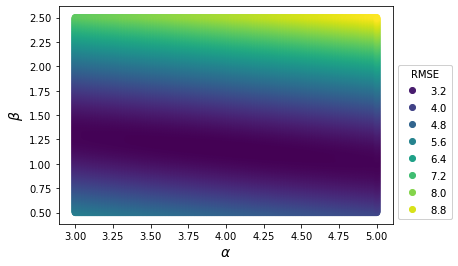

In [13]:
fig, ax = plt.subplots()

scatter = ax.scatter('intercept', 'slope', c='rmse', data=data)
legend  = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="RMSE", bbox_to_anchor=(1, 0))
ax.add_artist(legend)
ax.set_xlabel('$ \\alpha $', fontsize=14)
ax.set_ylabel('$ \\beta $', fontsize=14)

plt.show()

From this graph we can clearly see a region of combinations of values with lower RMSE values in comparison to the upper right and lower left corner. To find the index of the minimum RMSE value and corresponding parameter values we transform the data once more, this time into a *Pandas* dataframe.

Food for thought: can you explain the slightly negative relation between the intercept and slope values?*

In [14]:
import pandas as pd
data_df = pd.DataFrame(data)

In [15]:
# retrieve the index
low_idx = data_df['rmse'].idxmin()

In [16]:
# retrieve the values for the corresponding index
data_df.iloc[low_idx, ]

intercept    4.050100
slope        1.153307
rmse         2.713758
Name: 131163, dtype: float64

#### The moment of truth

This has all been a blast but I am sure you are wondering whether this result even comes close to the exact linear algebra result? Let's find out by using our beloved few lines of code approach, scikit-learn.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
X = x.reshape(-1, 1)

In [19]:
lin_model = LinearRegression()
lin_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
print(lin_model.intercept_, lin_model.coef_)

4.045454545454545 [1.15454545]


Not too shabby. 

### If you're being smart about being naive, you have a winner

The essence of what we have been doing is the following:
- We have defined possibly decent combinations of parameter values, also known as a *parameter space*
- We have defined a measure to formally check the best combination, also known as a *loss function*
- We have tried every possible combination, also known as a *brute force approach*

The process of searching and validating the best combinations of parameter values is very common in Machine Learning, also for much more complex challenges. A big difference between our naive approach and more sophisticated techniques is the search efficiency of the latter. The inner workings of these techniques are out of scope for this article but the following terms are related and worthwhile for further study (see Further studying for tips):

- (Stochastic) Gradient Descent
- Hyperparameter optimization 

If you are wondering whether we could not simply further expand our combinations for more complex challenges, realize that for this extremly simple example we already tried 250.000 different combinations, and we were lucky enough to narrow our search due to the visualizations. In almost any real life scenario this approach is not feasible due to time- and memory constraints. 

Regardless of the shortcomings, I hope this approach was helpful to create a mental picture when you are waiting for your notebook to finish after hitting the *fit* button.

### Further studying 

The following resources not only inspired this article, but are also (a lot of!) fun and interesting to study:

#### Books
- *An Introduction to Statistical Learning* by Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani 
- *Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow* by Aurelien Geron 
- *Statistical Rethinking* by Richard McElreath

#### Youtube Series
- [StatQuest](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw)
- [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw)

#### MOOC
- [Brilliant](https://brilliant.org/daily-problems/)

Do not forget to **enjoy the journey** since its all too easy to get hung up in the latest, newest, and coolest techniques. There is nothing wrong with getting the basics right.

\**The higher the intercept the lower the slope must be in order to remain close to these observed values, thereby minimizing the RMSE.* 